In [110]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [111]:
# load 6 modalites data 
from sklearn.utils import resample
import numpy as np
import pandas as pd

def load_data():
    cln_data = pd.read_csv('data/raw_features_cln.csv')
    cnv_data = pd.read_csv('data/raw_features_cnv.csv')
    dna_data = pd.read_csv('data/raw_features_dna.csv')
    mir_data = pd.read_csv('data/raw_features_mir.csv')
    mrna_data = pd.read_csv('data/raw_features_mrna.csv')
    wsi_data = pd.read_csv('data/raw_features_wsi.csv')

    # keep data where all modalities are present based on patient id
    patient_ids = set(cln_data['submitter_id.samples'])
    patient_ids = patient_ids.intersection(set(cnv_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(dna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mir_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mrna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(wsi_data['submitter_id.samples']))

    cln_data = cln_data[cln_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    cnv_data = cnv_data[cnv_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    dna_data = dna_data[dna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mir_data = mir_data[mir_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mrna_data = mrna_data[mrna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    wsi_data = wsi_data[wsi_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)

    # sort data by patient id
    cln_data = cln_data.sort_values('submitter_id.samples').reset_index(drop=True)
    cnv_data = cnv_data.sort_values('submitter_id.samples').reset_index(drop=True)
    dna_data = dna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mir_data = mir_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mrna_data = mrna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    wsi_data = wsi_data.sort_values('submitter_id.samples').reset_index(drop=True)

    # make sure the labels column match for all modalities
    cln_labels = cln_data['label_cln']
    cnv_labels = cnv_data['label_cnv']
    dna_labels = dna_data['label_dna']
    mir_labels = mir_data['label_mir']
    mrna_labels = mrna_data['label_mrna']
    wsi_labels = wsi_data['label_wsi']

    assert np.all(cln_labels == cnv_labels), "Labels mismatch between clinical and CNV data"
    assert np.all(cln_labels == dna_labels), "Labels mismatch between clinical and DNA data"
    assert np.all(cln_labels == mir_labels), "Labels mismatch between clinical and miRNA data"
    assert np.all(cln_labels == mrna_labels), "Labels mismatch between clinical and mRNA data"
    # assert np.all(cln_labels == wsi_labels), "Labels mismatch between clinical and WSI data"

    # drop labels column and patient id column
    cln_data = cln_data.drop(columns=['label_cln', 'submitter_id.samples'])
    cnv_data = cnv_data.drop(columns=['label_cnv', 'submitter_id.samples'])
    dna_data = dna_data.drop(columns=['label_dna', 'submitter_id.samples'])
    mir_data = mir_data.drop(columns=['label_mir', 'submitter_id.samples'])
    mrna_data = mrna_data.drop(columns=['label_mrna', 'submitter_id.samples'])
    wsi_data = wsi_data.drop(columns=['label_wsi', 'submitter_id.samples'])

    # normalize data
    stdscalar = StandardScaler()
    cln_data = stdscalar.fit_transform(cln_data)
    cnv_data = stdscalar.fit_transform(cnv_data)
    dna_data = stdscalar.fit_transform(dna_data)
    mir_data = stdscalar.fit_transform(mir_data)
    mrna_data = stdscalar.fit_transform(mrna_data)
    wsi_data = stdscalar.fit_transform(wsi_data)

    return cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, cln_labels


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def balance_modality_data(features_list, labels, method='SMOTE'):
    """
    Balances the dataset for each modality separately.
    
    Parameters:
    - features_list: List of feature matrices, one for each modality.
    - labels: Binary labels (numpy array or Series).
    - method: Balancing method ('SMOTE' supported here).
    
    Returns:
    - Separate balanced feature matrices for each modality.
    - Balanced labels (same across all modalities).
    """
    smote = SMOTE(random_state=42)
    balanced_features_list = []
    
    for modality_features in features_list:
        # Balance the current modality's features and labels
        balanced_modality_features, balanced_labels = smote.fit_resample(modality_features, labels)
        balanced_features_list.append(balanced_modality_features)
    
    # Unpack balanced features into separate variables and return them
    return (*balanced_features_list, balanced_labels)

if __name__ == '__main__':
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    
    # List of modalities
    features_list = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    
    # Balance the modalities and unpack them
    balanced_cln_data, balanced_cnv_data, balanced_dna_data, balanced_mir_data, balanced_mrna_data, balanced_wsi_data, balanced_labels = balance_modality_data(features_list, labels, method='SMOTE')
    
    # Print shapes
    print("\nBalanced shapes of modalities:")
    print(f"Clinical: {balanced_cln_data.shape}")
    print(f"CNV: {balanced_cnv_data.shape}")
    print(f"DNA: {balanced_dna_data.shape}")
    print(f"miRNA: {balanced_mir_data.shape}")
    print(f"mRNA: {balanced_mrna_data.shape}")
    print(f"WSI: {balanced_wsi_data.shape}")
    print(f"Labels: {balanced_labels.shape}")

    # Class distribution
    print("\nClass distribution after balancing:")
    print(f"Positive samples: {np.sum(balanced_labels == 1)}")
    print(f"Negative samples: {np.sum(balanced_labels == 0)}")




Balanced shapes of modalities:
Clinical: (1592, 19)
CNV: (1592, 500)
DNA: (1592, 500)
miRNA: (1592, 500)
mRNA: (1592, 500)
WSI: (1592, 800)
Labels: (1592,)

Class distribution after balancing:
Positive samples: 796
Negative samples: 796


In [116]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define a MultimodalDataset class if not already defined
class MultimodalDataset(Dataset):
    def __init__(self, *modalities, labels):
        self.modalities = modalities
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tuple(modality[idx] for modality in self.modalities) + (self.labels[idx],)


def load_and_split_data(modalities, labels, test_size=0.2, random_state=42):
    """
    Splits the data into train and test sets, and balances the test set.
    """
    # Split the data into train and test sets
    train_modalities, test_modalities = [], []
    for modality in modalities:
        train, test = train_test_split(modality, test_size=test_size, random_state=random_state)
        train_modalities.append(train)
        test_modalities.append(test)

    labels_train, labels_test = train_test_split(labels, test_size=test_size, random_state=random_state)

    return train_modalities, test_modalities, labels_train, labels_test

# Function to convert data to tensors
def convert_to_tensors(data):
    return [torch.tensor(modality, dtype=torch.float32) for modality in data]

# Main code
def get_train_test_loader():
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    # cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = balance_modality_data(modalities, labels)
    modalities = [cln_data, cnv_data, mrna_data]
    # Split data
    train_modalities, test_modalities, labels_train, labels_test = load_and_split_data(modalities, labels)

    # Convert data to tensors
    train_tensors = convert_to_tensors(train_modalities)
    test_tensors = convert_to_tensors(test_modalities)
    labels_train = torch.tensor(labels_train, dtype=torch.long)
    labels_test = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = MultimodalDataset(*train_tensors, labels=labels_train)
    test_dataset = MultimodalDataset(*test_tensors, labels=labels_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_modalities, test_modalities, labels_train, labels_test

# Run the main function
train_modalities, test_modalities, labels_train, labels_test = get_train_test_loader()


In [113]:
import networkx as nx
from torch_geometric.data import Data

# Step 1: Graph Creation
def create_graph(data, threshold):
    """
    Create a graph from the data where nodes represent patients and edges 
    are created based on a Pearson correlation threshold.
    
    Args:
    - data (numpy array): Feature matrix of shape (num_patients, num_features).
    - threshold (float): Correlation threshold for edge creation.
    
    Returns:
    - PyTorch Geometric Data object representing the graph.
    """
    num_patients = data.shape[0]
    graph = nx.Graph()

    # Add nodes
    graph.add_nodes_from(range(num_patients))

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(data)

    # Add edges based on threshold
    for i in range(num_patients):
        for j in range(i + 1, num_patients):
            if corr_matrix[i, j] > threshold:
                graph.add_edge(i, j)

    # Convert to PyTorch Geometric Data format
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(data, dtype=torch.float32)

    print(f'Number of nodes: {num_patients}, Number of edges: {edge_index.size(1)}')

    return Data(x=x, edge_index=edge_index)

In [119]:
graphs = [create_graph(data, threshold) for data, threshold in zip(train_modalities, thresholds)]

Number of nodes: 828, Number of edges: 301
Number of nodes: 828, Number of edges: 12342
Number of nodes: 828, Number of edges: 4449


In [114]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from itertools import combinations

# Step 2: GCN Model
class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 3: Sampling Pairs
def sample_pairs(labels):
    """
    Generate positive and negative pairs from the labels.

    Args:
    - labels (torch.Tensor): Labels of the nodes.

    Returns:
    - List[Tuple[int, int]]: Positive and negative pairs (indices of nodes).
    """
    positive_pairs = []
    negative_pairs = []
    for i, j in combinations(range(len(labels)), 2):
        if labels[i] == labels[j]:
            positive_pairs.append((i, j))
        else:
            negative_pairs.append((i, j))
    return positive_pairs, negative_pairs

# Step 4: Contrastive Loss
def pairwise_contrastive_loss(embeddings, positive_pairs, negative_pairs, margin=1.0):
    """
    Compute contrastive loss using sampled positive and negative pairs.

    Args:
    - embeddings (torch.Tensor): Embedding matrix.
    - positive_pairs (List[Tuple[int, int]]): Positive pairs.
    - negative_pairs (List[Tuple[int, int]]): Negative pairs.
    - margin (float): Margin for dissimilar embeddings.

    Returns:
    - torch.Tensor: Contrastive loss.
    """
    loss = 0.0

    # Positive pairs
    for i, j in positive_pairs:
        dist = torch.norm(embeddings[i] - embeddings[j])
        loss += dist ** 2  # Pull closer

    # Negative pairs
    for i, j in negative_pairs:
        dist = torch.norm(embeddings[i] - embeddings[j])
        loss += torch.clamp(margin - dist, min=0) ** 2  # Push apart

    return loss / (len(positive_pairs) + len(negative_pairs))

# Step 5: Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example thresholds and data
thresholds = [0.95, 0.9, 0.8]

# Create graphs for each modality
graphs = [create_graph(data, threshold) for data, threshold in zip(train_modalities, thresholds)]

# Initialize GCN models for each modality
gcn_models = []
cln_model = GCNEncoder(input_dim=balanced_cln_data.shape[1], hidden_dim=32, output_dim=16)
cnv_model = GCNEncoder(input_dim=balanced_cnv_data.shape[1], hidden_dim=32, output_dim=16)
dna_model = GCNEncoder(input_dim=balanced_dna_data.shape[1], hidden_dim=32, output_dim=16)
mir_model = GCNEncoder(input_dim=balanced_mir_data.shape[1], hidden_dim=32, output_dim=16)
mrna_model = GCNEncoder(input_dim=balanced_mrna_data.shape[1], hidden_dim=32, output_dim=16)
wsi_model = GCNEncoder(input_dim=balanced_wsi_data.shape[1], hidden_dim=32, output_dim=16)
gcn_models = [cln_model, cnv_model, mrna_model]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.01) for model in gcn_models]

# Training GCNs
epochs = 10
for i, (model, graph, optimizer) in enumerate(zip(gcn_models, graphs, optimizers)):
    print(f'Training GCN model {i}...')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        embeddings = model(graph.x, graph.edge_index)

        # Sample pairs and compute loss
        positive_pairs, negative_pairs = sample_pairs(labels_train)
        loss = pairwise_contrastive_loss(embeddings, positive_pairs, negative_pairs)

        # Backpropagation
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Concatenate embeddings from all modalities
all_embeddings = []
for model, graph in zip(gcn_models, graphs):
    model.eval()
    with torch.no_grad():
        embeddings = model(graph.x, graph.edge_index)
        all_embeddings.append(embeddings)
concatenated_embeddings = torch.cat(all_embeddings, dim=1)

# Initialize and train the classifier
classifier = Classifier(input_dim=concatenated_embeddings.size(1), hidden_dim=32, num_classes=2)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

print("Training classifier...")
for epoch in range(epochs):
    classifier.train()
    classifier_optimizer.zero_grad()
    
    # Forward pass and compute loss
    logits = classifier(concatenated_embeddings)
    classification_loss = F.cross_entropy(logits, labels_train)
    classification_loss.backward()
    classifier_optimizer.step()

    print(f'Epoch: {epoch}, Loss: {classification_loss.item()}')

print("Training complete.")


Number of nodes: 1273, Number of edges: 1539
Number of nodes: 1273, Number of edges: 9569
Number of nodes: 1273, Number of edges: 1066
Training GCN model 0...
Epoch: 0, Loss: 7.191842555999756
Epoch: 1, Loss: 5.279943943023682
Epoch: 2, Loss: 3.8726251125335693
Epoch: 3, Loss: 2.8523590564727783
Epoch: 4, Loss: 2.1233880519866943
Epoch: 5, Loss: 1.6098545789718628
Epoch: 6, Loss: 1.2529451847076416
Epoch: 7, Loss: 1.005657434463501
Epoch: 8, Loss: 0.8345305919647217
Epoch: 9, Loss: 0.7149323225021362
Training GCN model 1...
Epoch: 0, Loss: 14.431365013122559
Epoch: 1, Loss: 85.24732971191406
Epoch: 2, Loss: 33.933998107910156
Epoch: 3, Loss: 34.67918014526367
Epoch: 4, Loss: 29.4047908782959
Epoch: 5, Loss: 20.147443771362305
Epoch: 6, Loss: 16.933536529541016
Epoch: 7, Loss: 14.673105239868164
Epoch: 8, Loss: 11.570744514465332
Epoch: 9, Loss: 9.765456199645996
Training GCN model 2...
Epoch: 0, Loss: 16.304256439208984
Epoch: 1, Loss: 45.40164566040039
Epoch: 2, Loss: 17.8236789703369

Number of nodes: 207, Number of edges: 41
Number of nodes: 207, Number of edges: 538
Number of nodes: 207, Number of edges: 574


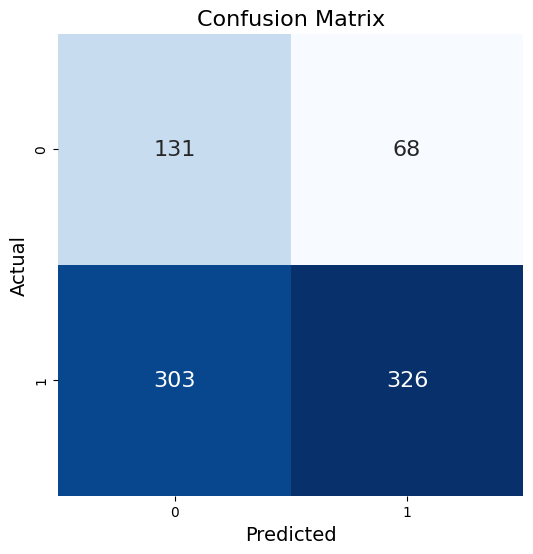

Test Accuracy: 0.5519
Test F1 Score: 0.5836
Test AUC: 0.6277
Test Specificity: 0.6583
Test Recall: 0.5183
Test Precision: 0.8274
Test MCC: 0.1511
Test AUPRC: 0.8337

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.66      0.41       199
           1       0.83      0.52      0.64       629

    accuracy                           0.55       828
   macro avg       0.56      0.59      0.53       828
weighted avg       0.70      0.55      0.58       828



In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import matthews_corrcoef, recall_score, precision_score, average_precision_score
import seaborn as sns
thresholds = [0.95, 0.7, 0.5, 0.5, 0.2]
# Create graphs for the test modalities
test_graphs = [create_graph(data, threshold) for data, threshold in zip(test_modalities, thresholds)]
# Generate embeddings for test graphs using trained GCN models
test_embeddings_list = []
for model, test_graph in zip(gcn_models, graphs):
    model.eval()
    with torch.no_grad():
        embeddings = model(test_graph.x, test_graph.edge_index)
        test_embeddings_list.append(embeddings)

# Concatenate embeddings across modalities
concatenated_test_embeddings = torch.cat(test_embeddings_list, dim=1)
# Evaluate the classifier on the test set
classifier.eval()
with torch.no_grad():
    test_logits = classifier(concatenated_test_embeddings)
    test_prob = F.softmax(test_logits, dim=1)
    test_pred = (test_prob[:, 1] > 0.5).long()

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Convert tensors to numpy arrays for metrics calculation
labels_test_np = labels_train.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()
test_prob_np = test_prob.cpu().numpy()

# Compute metrics
accuracy = accuracy_score(labels_test_np, test_pred_np)
f1 = f1_score(labels_test_np, test_pred_np, average='weighted')
auc = roc_auc_score(labels_test_np, test_prob_np[:, 1])
cm = confusion_matrix(labels_test_np, test_pred_np)
specificity = cm[0, 0] / cm[0, :].sum()
recall = recall_score(labels_test_np, test_pred_np)
precision = precision_score(labels_test_np, test_pred_np)
mcc = matthews_corrcoef(labels_test_np, test_pred_np)
auprc = average_precision_score(labels_test_np, test_prob_np[:, 1])
classification_rep = classification_report(labels_test_np, test_pred_np)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Specificity: {specificity:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test MCC: {mcc:.4f}")
print(f"Test AUPRC: {auprc:.4f}")
print("\nClassification Report:")
print(classification_rep)
